In [5]:
import numpy as np

def get_random_color(pastel_factor=0.5):
    return [(x + pastel_factor) / (1.0 + pastel_factor)
            for x in [np.random.uniform(0, 1.0) for i in [1, 2, 3]]]

def color_distance(c1, c2):
    return sum([abs(x[0] - x[1]) for x in zip(c1, c2)])

def generate_new_color(existing_colors, pastel_factor=0.5):
    max_distance = None
    best_color = None
    for i in range(0, 100):
        color = get_random_color(pastel_factor=pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color, c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

def get_n_colors(n, pastel_factor=0.9):
    colors = []
    for i in range(n):
        colors.append(generate_new_color(colors, pastel_factor=0.9))
    return colors

In [6]:
import matplotlib.pyplot as plt

from torchvision import transforms
from matplotlib.patches import Circle
from PIL import Image, ImageDraw
import os
import torch
from skills.video_object_keypoints import Transporter, ObjectKeypointsDataset, ObjectKeypointsSampler
from torch.utils.data import DataLoader, Sampler


image_channels = 1
K = 4

game = "pong"
model_path = "./skills/torch_models/vid-obj-key.pt"
data_path = "./data_pt"
batch_size = 16


model = Transporter(inp_ch=image_channels, K=K).to("cpu")
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
#data_path = f"../../data_expert/{ENV}"

t_dataset = ObjectKeypointsDataset(data_path, transform=None, game="pong")
t_sampler = ObjectKeypointsSampler(t_dataset)

# CRITICAL: Use num_workers > 0 for parallel data loading
# pin_memory=True speeds up CPU->GPU transfer

num_workers = 6

t_data_loader = DataLoader(
    t_dataset,
    batch_size=batch_size,
    sampler=t_sampler,
    num_workers=num_workers,  # Adjust based on your CPU cores
    pin_memory=True,  # Faster CPU->GPU transfer
    persistent_workers=True,  # Keep workers alive between epochs
    prefetch_factor=2
)

v_dataset = ObjectKeypointsDataset(data_path, transform=None, game="pong")
v_sampler = ObjectKeypointsSampler(v_dataset)
v_data_loader = DataLoader(
    v_dataset,
    batch_size=2*batch_size,
    sampler=v_sampler,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)
xt, xtp1 = next(iter(t_data_loader))


target_keypoints = model.key_net(xtp1)
reconstruction = model(xt, xtp1)

out1 = model.encoder(xtp1)
out2 = model.key_net(xtp1)
print("Encoder", out1.shape)
print("keypoints", out2.shape) #number of images * number of keypoints founded * width * height
print("reconstruction", reconstruction.shape)

Caching episode lengths...
Cached 24 episodes
Building episode metadata cache...
Cached 24 valid episodes
Caching episode lengths...
Cached 24 episodes
Building episode metadata cache...
Cached 24 valid episodes


c:\Users\giaco\VSCode Projects\medium-articles\skill-based-agents\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Encoder torch.Size([16, 128, 21, 21])
keypoints torch.Size([16, 4, 21, 21])
reconstruction torch.Size([16, 1, 84, 84])


locs torch.Size([4, 2])


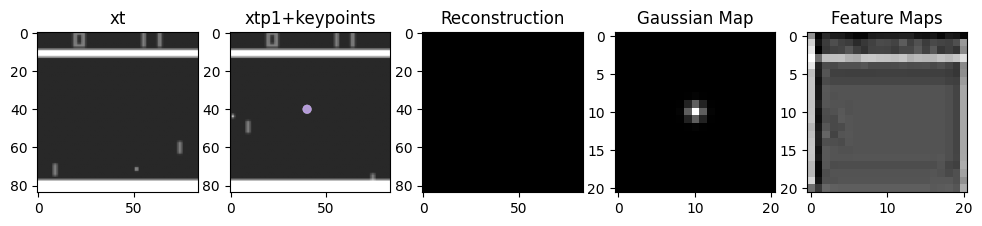

In [7]:
from skills.video_object_keypoints import spatial_softmax, gaussian_map, compute_keypoint_location_mean

fig, ax = plt.subplots(1, 5, figsize=(12, 4))
idx = 1
k_idx = 1
std = 0.1

feature_maps = spatial_softmax(target_keypoints)
gmap = gaussian_map(feature_maps, std)[idx, k_idx]

ax[0].imshow(xt[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[1].imshow(xtp1[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[2].imshow(reconstruction[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[3].imshow(gmap.detach().numpy(), cmap='gray', vmin=0, vmax=1)
ax[4].imshow(feature_maps[idx, k_idx].detach().numpy(), cmap='gray')

ax[0].title.set_text('xt')
ax[1].title.set_text('xtp1+keypoints')
ax[2].title.set_text('Reconstruction')
ax[3].title.set_text('Gaussian Map')
ax[4].title.set_text('Feature Maps')

locs = compute_keypoint_location_mean(
    spatial_softmax(model.key_net(xtp1)))[idx]

print("locs", locs.shape)

# set keypoints over image
colors = get_n_colors(len(locs))
for i, l in enumerate((locs + 1) / 2 * 80):
    ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2,
                           color=colors[i], alpha=0.5))


plt.show()